# Analysing Adult Data

In [18]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from scipy.stats import ttest_ind
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import PCA
import statsmodels.formula.api as smf
from scipy.stats import f_oneway
from statsmodels.formula.api import ols
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.ensemble import GradientBoostingRegressor
from datetime import timedelta

### Loading the datasets

In [19]:
adults = pd.read_csv("data_adults.csv")
#df_weighted = pd.read_csv("weight_subcat.csv")
df_weighted = pd.read_csv("df_delete.csv")

Session 1 scores will be taken as the baseline scores. First, we wish to check the relationship of the baseline scores with the hair and saliva cortisol levels. Second, we would be checking the predictive relationship of baseline subluxation levels and the hair and saliva cortisol levels. We will assume baseline subluxation as the independent variable, and the hair and saliva cortisol levels as the dependent variables.

we will also extract the subluxation scores for each patient's last session and will create a new column with these values. These will act as the subluxation scores after the 12 week intervention.

In [20]:
# Step 1: Select only columns containing "Weighted Sum"
weighted_sum_cols = [col for col in adults.columns if "Weighted Sum" in col]

# Step 2: Get the last non-zero value in each row from selected columns
adults['Last Intervention Score'] = adults[weighted_sum_cols].apply(
    lambda row: row[row != 0].dropna().iloc[-1] if (row[row != 0].dropna().size > 0) else None, axis=1
)

# Step 3: Extract session time columns (excluding Weighted Sum ones)
time_cols = [col for col in adults.columns if col.startswith('Session') and 'Weighted Sum' not in col]

# Step 4: Convert session time strings to datetime (ISO format like '2022-04-22 13:50:00')
df_time = adults[time_cols].apply(pd.to_datetime, errors='coerce')

# Step 5: Get the first session date per row
first_session = df_time.min(axis=1)

# Step 6: Initialize the new column
adults['Mid Intervention Score'] = None

# Step 7: Loop to extract the score 42 days after the first session
for idx in adults.index:
    base_date = first_session.loc[idx]
    if pd.isnull(base_date):
        continue

    # Target is 42 days after base
    target_date = base_date + timedelta(days=42)

    # Get session columns on or after this date
    session_times = df_time.loc[idx]
    future_sessions = session_times[session_times >= target_date].sort_values()

    if not future_sessions.empty:
        session_col = future_sessions.index[0]  # Get first session after 42 days
        weighted_sum_col = session_col + ' Weighted Sum'

        if weighted_sum_col in df_weighted.columns:
            adults.at[idx, 'Mid Intervention Score'] = adults.at[idx, weighted_sum_col]

# Resulting DataFrame
adults

,Unnamed: 0,ID,Enrolment Date,Initial Care Plan,Age Group,Active/Passive,Session 1,Session 1 Weighted Sum,Session 1 Cervical,Session 1 Lumbar,...,Depression_Baseline,Depression_Week 12,Depression_Week 16,Depression_Week 6,Stress_Baseline,Stress_Week 12,Stress_Week 16,Stress_Week 6,Last Intervention Score,Mid Intervention Score
0,0.0,1,20/4,3x4,Adults,Active,2022-04-20 14:00:00,26.0,15.0,2.0,...,8.5,8.5,5.0,9.0,11.0,6.0,7.0,13.0,10.0,26.0
1,1.0,2,20/4,3x4,Adults,Active,2022-04-20 12:35:00,19.0,8.0,3.0,...,7.0,0.0,0.0,5.0,8.0,1.0,1.0,9.0,16.0,19.0
2,2.0,4,19/4,3x4,Adults,Active,2022-04-19 12:55:00,17.0,9.0,0.0,...,1.0,NaN,NaN,0.0,2.0,NaN,NaN,0.0,12.0,17.0
3,3.0,5,21/4,3x4,Adults,Active,2022-04-21 12:35:00,25.0,13.0,5.0,...,0.0,5.0,0.0,0.0,2.0,9.0,0.0,0.0,12.0,25.0
4,4.0,6,20/4,3x4,Adults,Active,2022-04-20 13:40:00,24.0,15.0,2.0,...,7.0,10.0,4.0,4.0,11.0,9.0,4.0,9.0,17.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,192.0,217,NaN,2x6,Adults,Passive,2022-06-02 10:35:00,23.0,13.0,0.0,...,3.0,0.0,1.0,0.0,5.0,0.0,1.0,1.0,31.0,23.0
119,193.0,220,NaN,2x6,Adults,Passive,2022-06-02 10:28:00,24.0,13.0,0.0,...,2.0,0.0,NaN,NaN,3.5,0.0,NaN,NaN,22.0,24.0
120,194.0,221,2022-09-06 00:00:00,NaN,Adults,Passive,NaT,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,21.0
121,195.0,223,2022-09-06 00:00:00,NaN,Adults,Passive,2022-06-09 08:44:00,22.0,15.0,0.0,...,0.0,NaN,1.0,0.0,0.0,NaN,2.0,1.0,25.0,22.0


### Correlation between the variables

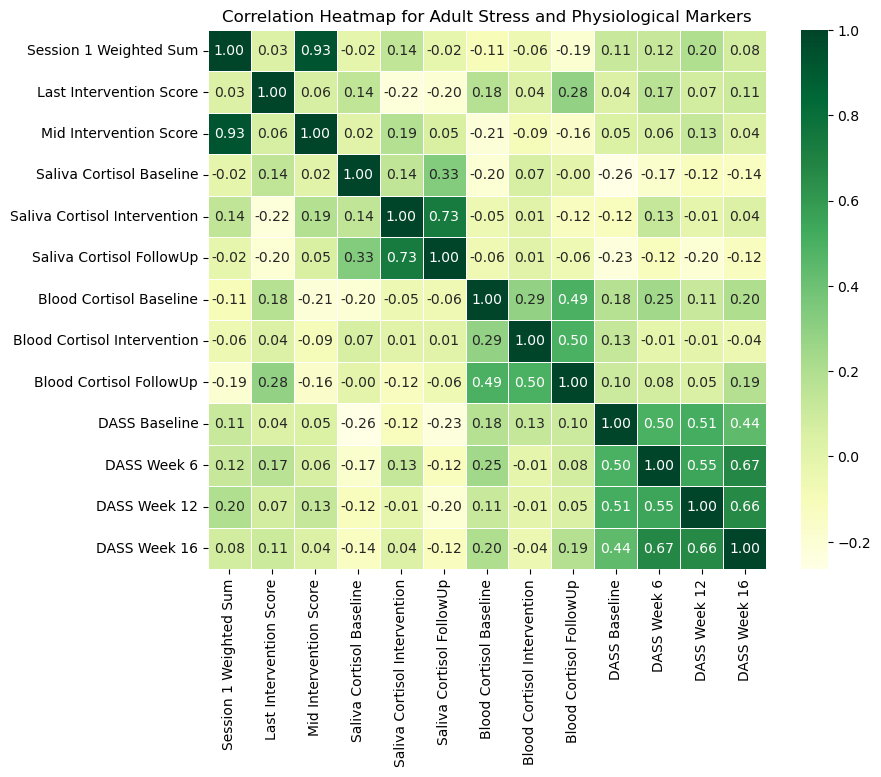

In [21]:
# Select specific columns
columns_to_plot = ["Session 1 Weighted Sum", "Last Intervention Score", "Mid Intervention Score", 
                   "Saliva Cortisol Baseline", "Saliva Cortisol Intervention", "Saliva Cortisol FollowUp", 
                   "Blood Cortisol Baseline", "Blood Cortisol Intervention", "Blood Cortisol FollowUp", "DASS Baseline", "DASS Week 6", "DASS Week 12", "DASS Week 16"]  
corr_matrix = adults[columns_to_plot].corr(method='spearman')

# Create a heatmap
plt.figure(figsize=(9, 7))
sns.heatmap(corr_matrix, annot=True, cmap="YlGn", fmt=".2f", linewidths=0.5)

# Add title
plt.title("Correlation Heatmap for Adult Stress and Physiological Markers")
plt.show()

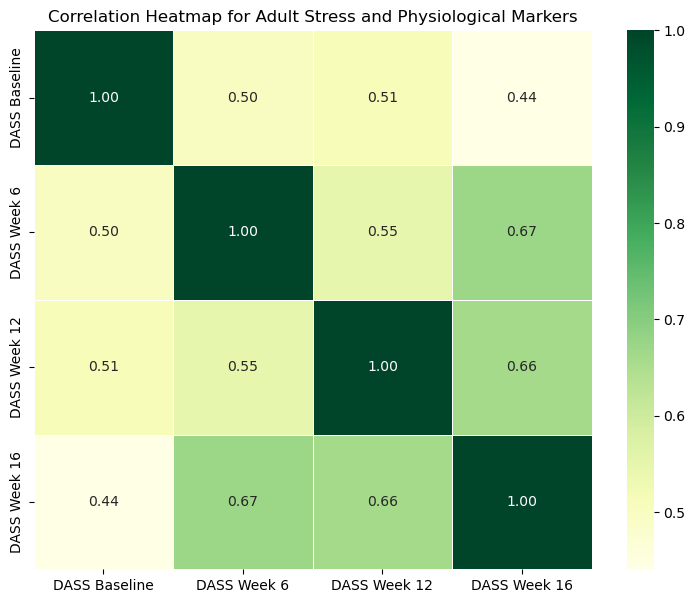

In [22]:
# Select specific columns
columns_to_plot = [
                   "DASS Baseline", "DASS Week 6", "DASS Week 12", "DASS Week 16"]  
corr_matrix = adults[columns_to_plot].corr(method='spearman')

# Create a heatmap
plt.figure(figsize=(9, 7))
sns.heatmap(corr_matrix, annot=True, cmap="YlGn", fmt=".2f", linewidths=0.5)

# Add title
plt.title("Correlation Heatmap for Adult Stress and Physiological Markers")
plt.show()

# Predicting Stress Outcomes using Subluxation Scores

In [6]:

# Assuming your DataFrame is called df and the column to transform is 'your_variable'
adults['BloodBaseline_log'] = np.log(adults['Blood Cortisol Baseline'] + 1)
adults['BloodPost_log'] = np.log(adults['Blood Cortisol Intervention'] + 1)
adults['BloodFollow_log'] = np.log(adults['Blood Cortisol FollowUp'] + 1)
adults['SalivaBaseline_log'] = np.log(adults['Saliva Cortisol Baseline'] + 1)
adults['SalivaFollow_log'] = np.log(adults['Saliva Cortisol FollowUp'] + 1)
adults['SalivaPost_log'] = np.log(adults['Saliva Cortisol Intervention'] + 1)
adults['DASSBaseline_log'] = np.log(adults['DASS Baseline'] + 1)
adults['DASSWeek6_log'] = np.log(adults['DASS Week 6'] + 1)
adults['DASSWeek12_log'] = np.log(adults['DASS Week 12'] + 1)
adults['DASSWeek16_log'] = np.log(adults['DASS Week 16'] + 1)
adults['LastScore_log'] = np.log(adults['Last Intervention Score'] + 1)

## Predicting Post- Intervention DASS Scores using Baseline and Mid-Intervention Variables

### SVR 

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'C': 10, 'epsilon': 0.1, 'gamma': 1}
Cross-validated R²: Mean=0.04, Std=0.14
Cross-validated RMSE: 9.85
Test Set R²: 0.09
Test Set RMSE: 8.54


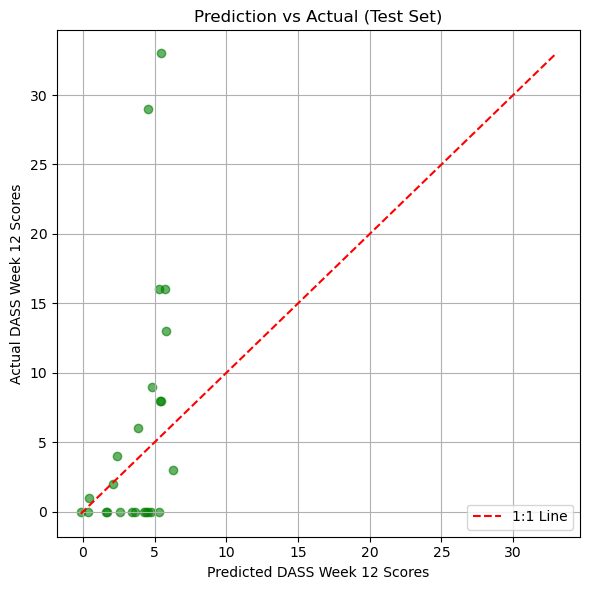

In [23]:
# ---------------------------
# 1. Fill missing values and encode
# ---------------------------
adults_filled = adults.fillna(0)

# Step 2: Encode Active/Passive
adults_filled['Active_Passive_Encoded'] = adults_filled['Active/Passive'].map({'Passive': 0, 'Active': 1})
adults_filled['Active_Passive_Encoded'] = adults_filled['Active_Passive_Encoded'].fillna(0)




# ---------------------------
# 2. Train/test split
# ---------------------------
train, test = train_test_split(adults_filled, test_size=0.2, random_state=42)
train = train.sort_values('Last Intervention Score')
test = test.sort_values('Last Intervention Score')

# ---------------------------
# 3. Select features/target
# ---------------------------
features = ['Last Intervention Score', 'DASS Baseline', 'DASS Week 6', 'Mid Intervention Score', 'Blood Cortisol Baseline', 'Saliva Cortisol Baseline', 'Active_Passive_Encoded']
X_train = train[features]
X_test = test[features]
y_train = train['DASS Week 12']
y_test = test['DASS Week 12']

# ---------------------------
# 4. Standardize features
# ---------------------------
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ---------------------------
# 5. Hyperparameter tuning (RBF SVR)
# ---------------------------
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.1, 1],
    'epsilon': [0.01, 0.1, 0.5]
}

svr = SVR(kernel='rbf')
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

best_svr = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# ---------------------------
# 6. Cross-validation on train set
# ---------------------------
cv_scores = cross_val_score(best_svr, X_train_scaled, y_train, cv=5, scoring='r2')
cv_predictions = cross_val_predict(best_svr, X_train_scaled, y_train, cv=5)
cv_rmse = round(np.sqrt(metrics.mean_squared_error(y_train, cv_predictions)), 2)

print(f"Cross-validated R²: Mean={cv_scores.mean():.2f}, Std={cv_scores.std():.2f}")
print(f"Cross-validated RMSE: {cv_rmse}")

# ---------------------------
# 7. Fit best model to train and evaluate on test set
# ---------------------------
best_svr.fit(X_train_scaled, y_train)
y_test_pred = best_svr.predict(X_test_scaled)
test_r2 = round(metrics.r2_score(y_test, y_test_pred), 2)
test_rmse = round(np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)), 2)

print(f"Test Set R²: {test_r2}")
print(f"Test Set RMSE: {test_rmse}")

# ---------------------------
# 8. Plot Predictions vs Actual (Test Set)
# ---------------------------
plt.figure(figsize=(6,6))
plt.scatter(y_test_pred, y_test, alpha=0.6, color='green')
min_val = min(y_test_pred.min(), y_test.min())
max_val = max(y_test_pred.max(), y_test.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='1:1 Line')
plt.xlabel('Predicted DASS Week 12 Scores')
plt.ylabel('Actual DASS Week 12 Scores')
plt.title('Prediction vs Actual (Test Set)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

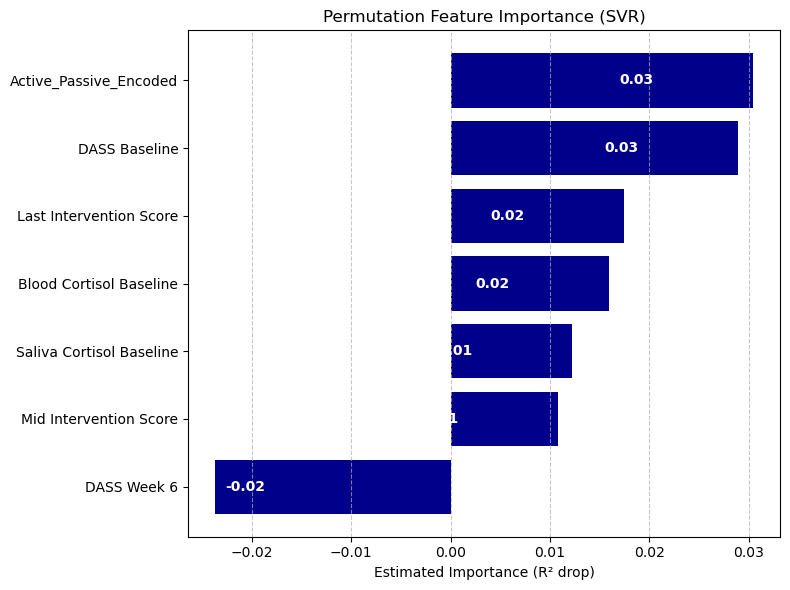

In [24]:
from sklearn.inspection import permutation_importance

# Compute permutation importances on the test set
perm_importance = permutation_importance(best_svr, X_test_scaled, y_test, n_repeats=30, random_state=42, scoring='r2')

# Create dataframe and sort
importances_df = pd.DataFrame({
    'Feature': features,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=True)

# Plot
plt.figure(figsize=(8, 6))
bars = plt.barh(importances_df['Feature'], importances_df['Importance'], color='darkblue')

# Add white value labels on bars
for bar in bars:
    width = bar.get_width()
    plt.text(width - 0.01 if width > 0.01 else width + 0.001,
             bar.get_y() + bar.get_height() / 2,
             f"{width:.2f}",
             va='center',
             ha='right' if width > 0.01 else 'left',
             color='white',
             fontweight='bold')

plt.xlabel("Estimated Importance (R² drop)")
plt.title("Permutation Feature Importance (SVR)")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [25]:
y_train_pred = best_svr.predict(X_train_scaled)
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(train_rmse)
print(train_r2)

6.975275437874177
0.5232932349491334


### Random Forest

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Tuned Random Forest CV R²: Mean=0.01, Std=0.22
Tuned Random Forest CV RMSE: 9.15
Tuned Random Forest Test Set R²: 0.47
Tuned Random Forest Test Set RMSE: 6.53


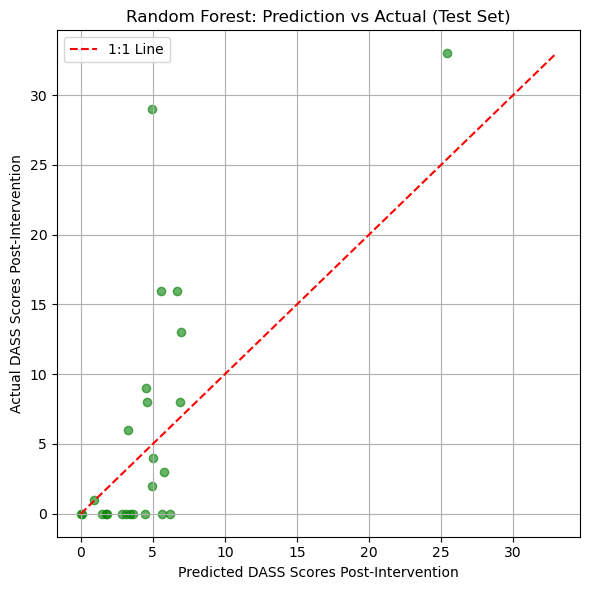

In [26]:
# ---------------------------
# 1. Define features and target
# ---------------------------
X = adults_filled[['Last Intervention Score', 'DASS Baseline', 'DASS Week 6', 'Mid Intervention Score', 'Blood Cortisol Baseline', 'Saliva Cortisol Baseline', 'Active_Passive_Encoded']]
y = adults_filled['DASS Week 12']

# ---------------------------
# 2. Train/test split (for later evaluation only)
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---------------------------
# 3. Define hyperparameter grid
# ---------------------------
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2]
}

# ---------------------------
# 4. Grid Search CV
# ---------------------------
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# ---------------------------
# 5. Cross-validation on full training set
# ---------------------------
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='r2')
cv_predictions = cross_val_predict(best_rf, X_train, y_train, cv=5)
cv_rmse = round(np.sqrt(metrics.mean_squared_error(y_train, cv_predictions)), 2)

print(f"Tuned Random Forest CV R²: Mean={cv_scores.mean():.2f}, Std={cv_scores.std():.2f}")
print(f"Tuned Random Forest CV RMSE: {cv_rmse}")

# ---------------------------
# 6. Fit best model and test set evaluation
# ---------------------------
best_rf.fit(X_train, y_train)
y_test_pred = best_rf.predict(X_test)

test_r2 = round(metrics.r2_score(y_test, y_test_pred), 2)
test_rmse = round(np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)), 2)

print(f"Tuned Random Forest Test Set R²: {test_r2}")
print(f"Tuned Random Forest Test Set RMSE: {test_rmse}")

# ---------------------------
# 7. Plot Predictions vs Actual on Test Set
# ---------------------------
plt.figure(figsize=(6, 6))
plt.scatter(y_test_pred, y_test, alpha=0.6, color='green')
min_val = min(min(y_test_pred), min(y_test))
max_val = max(max(y_test_pred), max(y_test))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='1:1 Line')
plt.xlabel("Predicted DASS Scores Post-Intervention")
plt.ylabel("Actual DASS Scores Post-Intervention")
plt.title("Random Forest: Prediction vs Actual (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

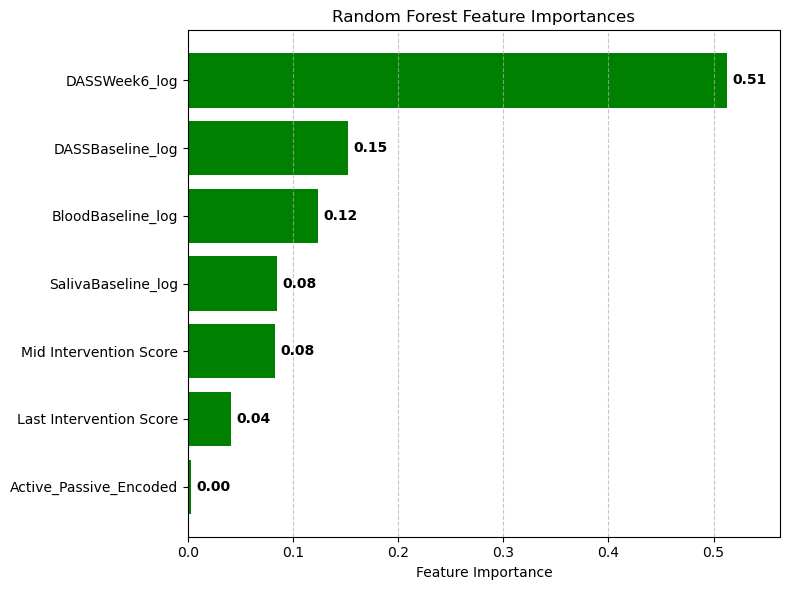

In [27]:
import matplotlib.pyplot as plt

# Sort the dataframe by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

# Plot
plt.figure(figsize=(8, 6))
bars = plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='green')

# Add values on bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, 
             bar.get_y() + bar.get_height() / 2,
             f"{width:.2f}",
             va='center',
             ha='left',
             color='black',
             fontweight='bold')

# Adjust x-axis limits to fit the text
max_width = feature_importance_df['Importance'].max()
plt.xlim(0, max_width + 0.05)

plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [28]:
y_train_pred_rf = best_rf.predict(X_train)
train_r2_rf = round(metrics.r2_score(y_train, y_train_pred_rf), 2)
train_rmse_rf = round(np.sqrt(metrics.mean_squared_error(y_train, y_train_pred_rf)), 2)

print(f"Random Forest - Training R²: {train_r2_rf}, RMSE: {train_rmse_rf}")


Random Forest - Training R²: 0.62, RMSE: 6.2


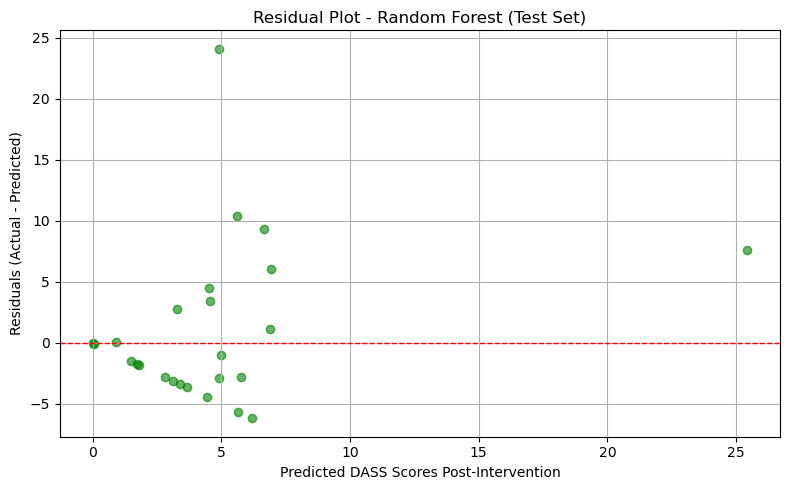

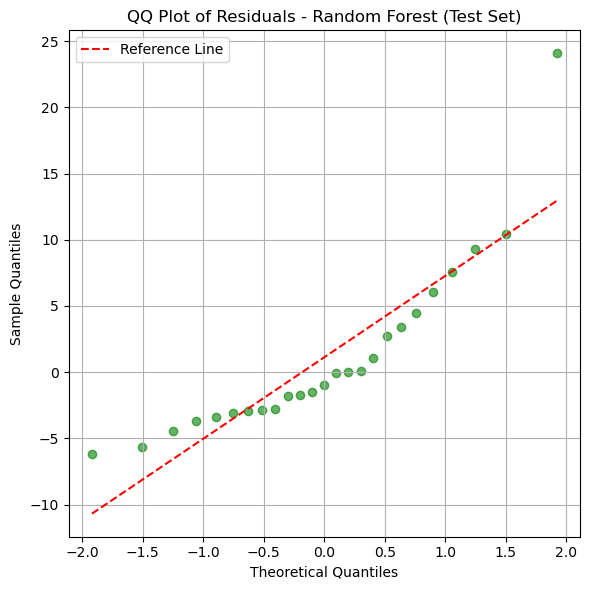

In [29]:
# ---------------------------
# 8. Calculate Residuals
# ---------------------------
residuals = y_test - y_test_pred

# Add residuals to a DataFrame for inspection if needed
residuals_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred,
    'Residual': residuals
})

# ---------------------------
# 9. Plot Residuals
# ---------------------------
plt.figure(figsize=(8, 5))
plt.scatter(y_test_pred, residuals, alpha=0.6, color='green')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel("Predicted DASS Scores Post-Intervention")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot - Random Forest (Test Set)")
plt.grid(True)
plt.tight_layout()
plt.show()


import scipy.stats as stats
# Create QQ plot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

# Generate QQ plot values
osm, osr = stats.probplot(residuals, dist="norm", plot=None)

# Scatter plot (green)
ax.scatter(osm[0], osm[1], color='green', alpha=0.6)

# Plot reference line
slope, intercept = osm[1][1], osm[1][0]
line = np.poly1d(np.polyfit(osm[0], osm[1], 1))
ax.plot(osm[0], line(osm[0]), color='red', linestyle='--', label='Reference Line')

ax.set_title("QQ Plot of Residuals - Random Forest (Test Set)")
ax.set_xlabel("Theoretical Quantiles")
ax.set_ylabel("Sample Quantiles")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

In [30]:
!pip install shap

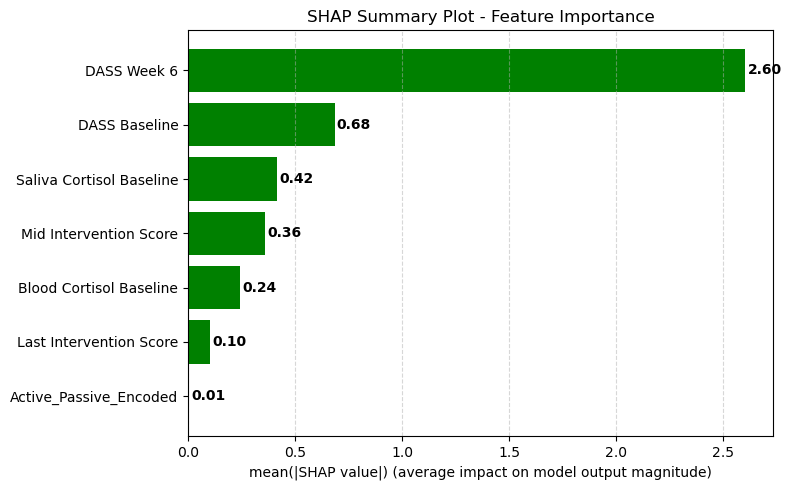

In [33]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# Create SHAP explainer and compute SHAP values
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)

# Get mean absolute SHAP values per feature
mean_abs_shap = np.abs(shap_values).mean(axis=0)
features = X_test.columns

# Sort by importance
sorted_idx = np.argsort(mean_abs_shap)[::-1]
sorted_shap = mean_abs_shap[sorted_idx]
sorted_features = features[sorted_idx]

# Plot
plt.figure(figsize=(8, 5))
bars = plt.barh(sorted_features[::-1], sorted_shap[::-1], color='green')  # reversed for top-down order

# Add values at the end of each bar
for bar, value in zip(bars, sorted_shap[::-1]):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f"{value:.2f}", va='center', ha='left', fontsize=10, fontweight='bold')

plt.xlabel("mean(|SHAP value|) (average impact on model output magnitude)")
plt.title("SHAP Summary Plot - Feature Importance")
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

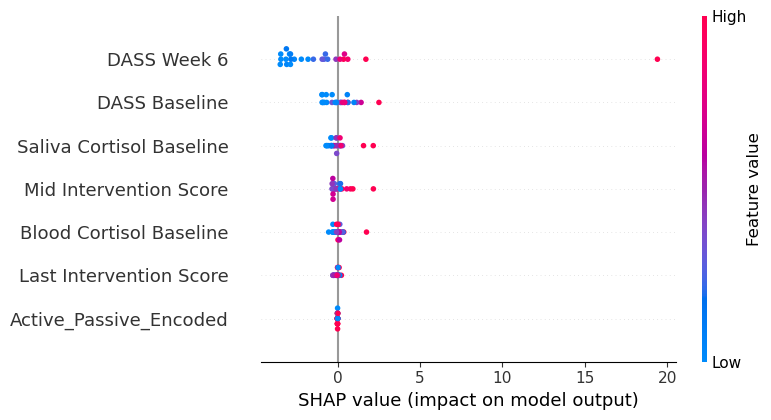

In [32]:
shap.summary_plot(shap_values, X_test)

### Gradient Boosting

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Tuned Gradient Boosting CV R²: Mean=0.01, Std=0.08
Tuned Gradient Boosting CV RMSE: 9.85
Tuned Gradient Boosting Test Set R²: 0.43
Tuned Gradient Boosting Test Set RMSE: 6.79


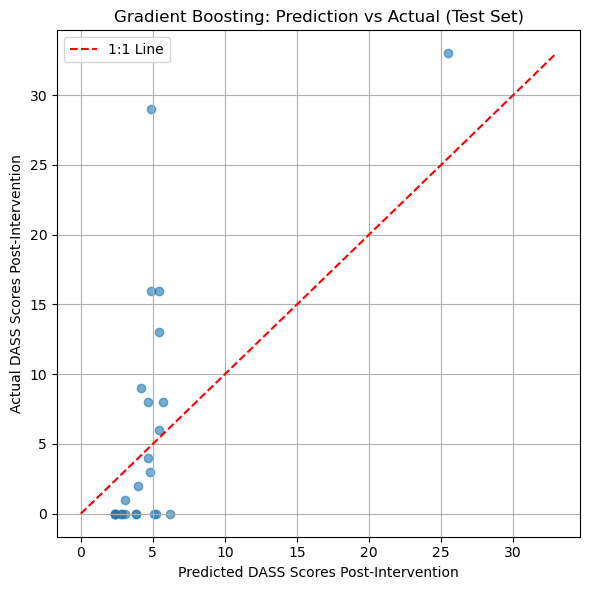

In [15]:
# ---------------------------
# 1. Define features and target
# ---------------------------
X = adults_filled[['Last Intervention Score', 'DASS Baseline', 'DASS Week 6', 'Mid Intervention Score', 'Blood Cortisol Baseline', 'Saliva Cortisol Baseline', 'Active_Passive_Encoded']]
y = adults_filled['DASS Week 12']

# ---------------------------
# 2. Train/test split
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---------------------------
# 3. Define hyperparameter grid
# ---------------------------
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# ---------------------------
# 4. Grid Search CV
# ---------------------------
gb = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(gb, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_gb = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# ---------------------------
# 5. Cross-validation on full training set
# ---------------------------
cv_scores = cross_val_score(best_gb, X_train, y_train, cv=5, scoring='r2')
cv_predictions = cross_val_predict(best_gb, X_train, y_train, cv=5)
cv_rmse = round(np.sqrt(metrics.mean_squared_error(y_train, cv_predictions)), 2)

print(f"Tuned Gradient Boosting CV R²: Mean={cv_scores.mean():.2f}, Std={cv_scores.std():.2f}")
print(f"Tuned Gradient Boosting CV RMSE: {cv_rmse}")

# ---------------------------
# 6. Fit best model and test set evaluation
# ---------------------------
best_gb.fit(X_train, y_train)
y_test_pred = best_gb.predict(X_test)

test_r2 = round(metrics.r2_score(y_test, y_test_pred), 2)
test_rmse = round(np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)), 2)

print(f"Tuned Gradient Boosting Test Set R²: {test_r2}")
print(f"Tuned Gradient Boosting Test Set RMSE: {test_rmse}")

# ---------------------------
# 7. Plot Predictions vs Actual on Test Set
# ---------------------------
plt.figure(figsize=(6, 6))
plt.scatter(y_test_pred, y_test, alpha=0.6)
min_val = min(min(y_test_pred), min(y_test))
max_val = max(max(y_test_pred), max(y_test))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='1:1 Line')
plt.xlabel("Predicted DASS Scores Post-Intervention")
plt.ylabel("Actual DASS Scores Post-Intervention")
plt.title("Gradient Boosting: Prediction vs Actual (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

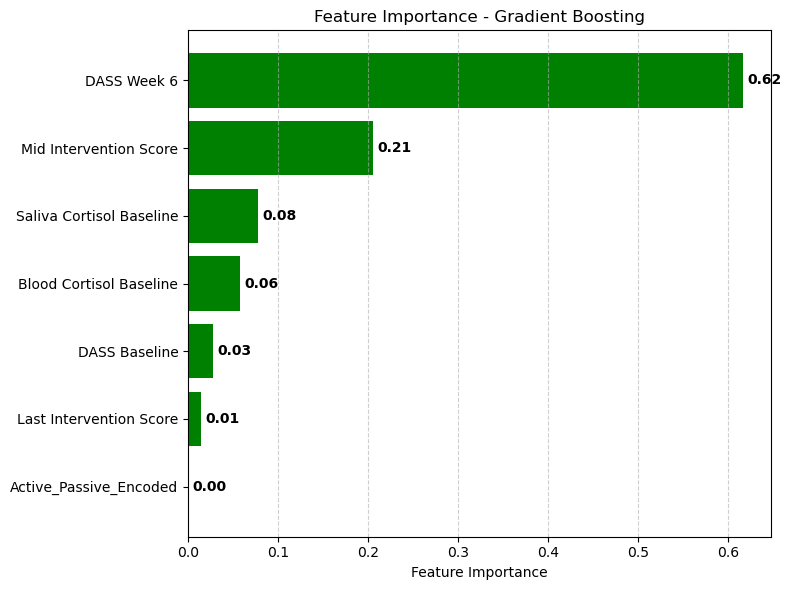

In [16]:
# Get feature importances and corresponding feature names
importances = best_gb.feature_importances_
features = X_train.columns

# Sort in descending order
indices = np.argsort(importances)[::-1]
sorted_features = features[indices]
sorted_importances = importances[indices]

# Plot
plt.figure(figsize=(8, 6))
bars = plt.barh(range(len(sorted_features)), sorted_importances[::-1], color='green')
plt.yticks(range(len(sorted_features)), sorted_features[::-1])
plt.xlabel('Feature Importance')
plt.title('Feature Importance - Gradient Boosting')

# Add white text labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height() / 2,
             f'{sorted_importances[::-1][i]:.2f}',
             va='center', ha='left', color='black', fontsize=10, fontweight='bold')

plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [17]:
y_train_pred_gb = best_gb.predict(X_train)
train_r2_gb = round(metrics.r2_score(y_train, y_train_pred_gb), 2)
train_rmse_gb = round(np.sqrt(metrics.mean_squared_error(y_train, y_train_pred_gb)), 2)

print(f"Gradient Boosting - Training R²: {train_r2_gb}, RMSE: {train_rmse_gb}")


Gradient Boosting - Training R²: 0.72, RMSE: 5.3


In [18]:
y_train_pred_ensemble = (y_train_pred_rf + y_train_pred_gb) / 2
train_r2_ensemble = round(metrics.r2_score(y_train, y_train_pred_ensemble), 2)
train_rmse_ensemble = round(np.sqrt(metrics.mean_squared_error(y_train, y_train_pred_ensemble)), 2)

print(f"Ensemble Model - Training R²: {train_r2_ensemble}, RMSE: {train_rmse_ensemble}")

from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# 1. Get predictions from both models on test set
y_pred_rf = best_rf.predict(X_test)
y_pred_gb = best_gb.predict(X_test)

# 2. Average predictions
y_pred_ensemble = (y_pred_rf + y_pred_gb) / 2

# 3. Evaluate ensemble
ensemble_r2 = round(r2_score(y_test, y_pred_ensemble), 2)
ensemble_rmse = round(np.sqrt(mean_squared_error(y_test, y_pred_ensemble)), 2)

print(f"Ensemble Model Test R²: {ensemble_r2}")
print(f"Ensemble Model Test RMSE: {ensemble_rmse}")

Ensemble Model - Training R²: 0.71, RMSE: 5.47
Ensemble Model Test R²: 0.45
Ensemble Model Test RMSE: 6.64


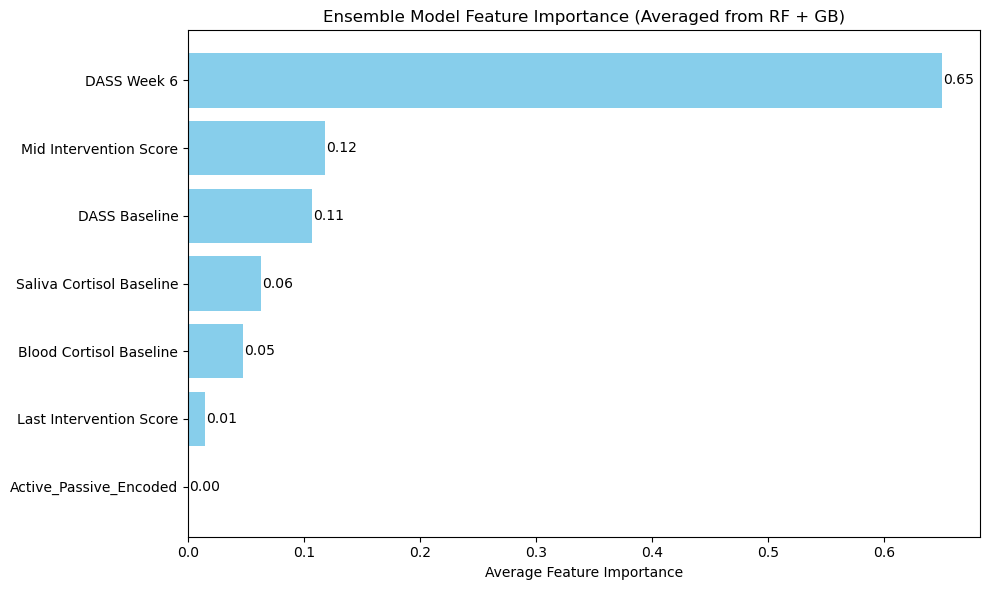

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Get feature importances from both models
rf_importances = best_rf.feature_importances_
gb_importances = best_gb.feature_importances_

# 2. Average the importances
avg_importances = (rf_importances + gb_importances) / 2

# 3. Create DataFrame for plotting
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Ensemble Importance': avg_importances
}).sort_values(by='Ensemble Importance', ascending=False)

# 4. Plot with values on bars
plt.figure(figsize=(10, 6))
bars = plt.barh(importance_df['Feature'], importance_df['Ensemble Importance'], color='skyblue')
plt.xlabel('Average Feature Importance')
plt.title('Ensemble Model Feature Importance (Averaged from RF + GB)')
plt.gca().invert_yaxis()

# Add values on bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
             f'{width:.2f}', va='center')

plt.tight_layout()
plt.show()

# Predicting Post-Intervention Blood Cortisol levels

## Linear Regression Model

In [20]:
adults_active = adults_filled[adults_filled["Active_Passive_Encoded"] == 1]
adults_passive = adults_filled[adults_filled["Active_Passive_Encoded"] == 0]

In [21]:
# 1. Fill missing values
adults_filled = adults.fillna(0)

# Step 2: Encode Active/Passive
adults_filled['Active_Passive_Encoded'] = adults_filled['Active/Passive'].map({'Passive': 0, 'Active': 1})
adults_filled['Active_Passive_Encoded'] = adults_filled['Active_Passive_Encoded'].fillna(0)

# 2. Rename columns
df_renamed = adults_filled.rename(columns={
    "Last Intervention Score": "Last_Intervention_Score",
    "Session 1 Weighted Sum": "Baseline_Score",
    "Mid Intervention Score": "Mid_Score",
    "Active/Passive": "Active_Passive",
    "DASS Week 16": "DASS_Week_16",
    "DASS Week 12": "DASS_Week_12",
    "DASS Week 6": "DASS_Week_6",
    "DASS Baseline": "DASS_Baseline",
    "Blood Cortisol Baseline": "Blood_Cortisol_Baseline",
    "Blood Cortisol Intervention": "Blood_Cortisol_Intervention",
    "Saliva Cortisol Baseline": "Saliva_Cortisol_Baseline",
    "Saliva Cortisol Intervention": "Saliva_Cortisol_Intervention"
})

# 3. Train-test split
train_df, test_df = train_test_split(df_renamed, test_size=0.2, random_state=42)

# 4. Train the model on the training set
mod1 = smf.ols(
    formula="Blood_Cortisol_Intervention ~ Blood_Cortisol_Baseline + Saliva_Cortisol_Baseline + DASS_Baseline + Baseline_Score + Mid_Score + DASS_Week_6 + C(Active_Passive_Encoded)",
    data=train_df
)
mod1_res = mod1.fit()

# 5. Print training summary
print(mod1_res.summary())

# 6. Predict on test set
y_pred = mod1_res.predict(test_df)

# 7. Evaluate on test set using R² (correct target!)
test_r2 = r2_score(test_df['Blood_Cortisol_Intervention'], y_pred)
print(f"\nTest Set R²: {test_r2:.2f}")

# 8. Cross-validation
# Select feature columns and target
feature_cols = ['Baseline_Score', 'Mid_Score', 'Saliva_Cortisol_Baseline', 'Blood_Cortisol_Baseline', 'DASS_Baseline', 'DASS_Week_6', 'Active_Passive_Encoded']
X_cv = df_renamed[feature_cols]
X_cv = pd.get_dummies(X_cv, drop_first=True)  # One-hot encode categorical variables
y_cv = df_renamed['Blood_Cortisol_Intervention']

# Define linear regression model
lr = LinearRegression()

# Perform 5-fold cross-validation for R²
cv_scores = cross_val_score(lr, X_cv, y_cv, cv=5, scoring='r2')

# Report cross-validation results
print(f"\nCross-validated R²: Mean={cv_scores.mean():.2f}, Std={cv_scores.std():.2f}")

                                 OLS Regression Results                                
Dep. Variable:     Blood_Cortisol_Intervention   R-squared:                       0.613
Model:                                     OLS   Adj. R-squared:                  0.583
Method:                          Least Squares   F-statistic:                     20.36
Date:                         Fri, 16 May 2025   Prob (F-statistic):           3.86e-16
Time:                                 10:29:29   Log-Likelihood:                -421.71
No. Observations:                           98   AIC:                             859.4
Df Residuals:                               90   BIC:                             880.1
Df Model:                                    7                                         
Covariance Type:                     nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------

## SVR

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'C': 100, 'epsilon': 0.01, 'gamma': 0.01}
Cross-validated R²: Mean=0.59, Std=0.17
Cross-validated RMSE: 18.39
Test Set R²: 0.49
Test Set RMSE: 14.61


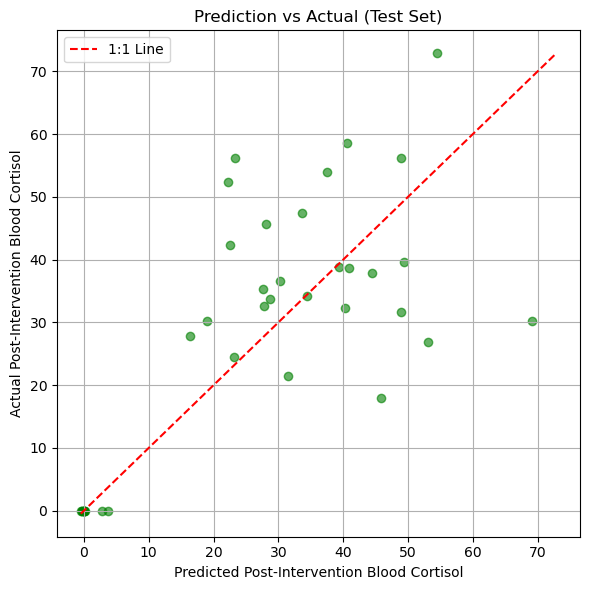

In [78]:
# ---------------------------
# 1. Fill missing values and encode
# ---------------------------
#adults_filled = adults.fillna(0)
# Step 2: Encode Active/Passive
adults_filled['Active_Passive_Encoded'] = adults_filled['Active/Passive'].map({'Passive': 0, 'Active': 1})
adults_filled['Active_Passive_Encoded'] = adults_filled['Active_Passive_Encoded'].fillna(0)
# ---------------------------
# 2. Train/test split
# ---------------------------
train, test = train_test_split(adults_filled, test_size=0.3, random_state=42)
train = train.sort_values('Last Intervention Score')
test = test.sort_values('Last Intervention Score')

# ---------------------------
# 3. Select features/target
# ---------------------------
features = ['Last Intervention Score', 'Blood Cortisol Baseline',  'Saliva Cortisol Baseline', 'DASS Baseline', 'DASS Week 6', 'Mid Intervention Score', 'Active_Passive_Encoded']
X_train = train[features]
X_test = test[features]
y_train = train['Blood Cortisol Intervention']
y_test = test['Blood Cortisol Intervention']

# ---------------------------
# 4. Standardize features
# ---------------------------
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ---------------------------
# 5. Hyperparameter tuning (RBF SVR)
# ---------------------------
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.1, 1],
    'epsilon': [0.01, 0.1, 0.5]
}

svr = SVR(kernel='rbf')
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

best_svr = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# ---------------------------
# 6. Cross-validation on train set
# ---------------------------
cv_scores = cross_val_score(best_svr, X_train_scaled, y_train, cv=5, scoring='r2')
cv_predictions = cross_val_predict(best_svr, X_train_scaled, y_train, cv=5)
cv_rmse = round(np.sqrt(metrics.mean_squared_error(y_train, cv_predictions)), 2)

print(f"Cross-validated R²: Mean={cv_scores.mean():.2f}, Std={cv_scores.std():.2f}")
print(f"Cross-validated RMSE: {cv_rmse}")

# ---------------------------
# 7. Fit best model to train and evaluate on test set
# ---------------------------
best_svr.fit(X_train_scaled, y_train)
y_test_pred = best_svr.predict(X_test_scaled)
test_r2 = round(metrics.r2_score(y_test, y_test_pred), 2)
test_rmse = round(np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)), 2)

print(f"Test Set R²: {test_r2}")
print(f"Test Set RMSE: {test_rmse}")

# ---------------------------
# 8. Plot Predictions vs Actual (Test Set)
# ---------------------------
plt.figure(figsize=(6,6))
plt.scatter(y_test_pred, y_test, alpha=0.6, color='green')
min_val = min(y_test_pred.min(), y_test.min())
max_val = max(y_test_pred.max(), y_test.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='1:1 Line')
plt.xlabel('Predicted Post-Intervention Blood Cortisol')
plt.ylabel('Actual Post-Intervention Blood Cortisol')
plt.title('Prediction vs Actual (Test Set)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

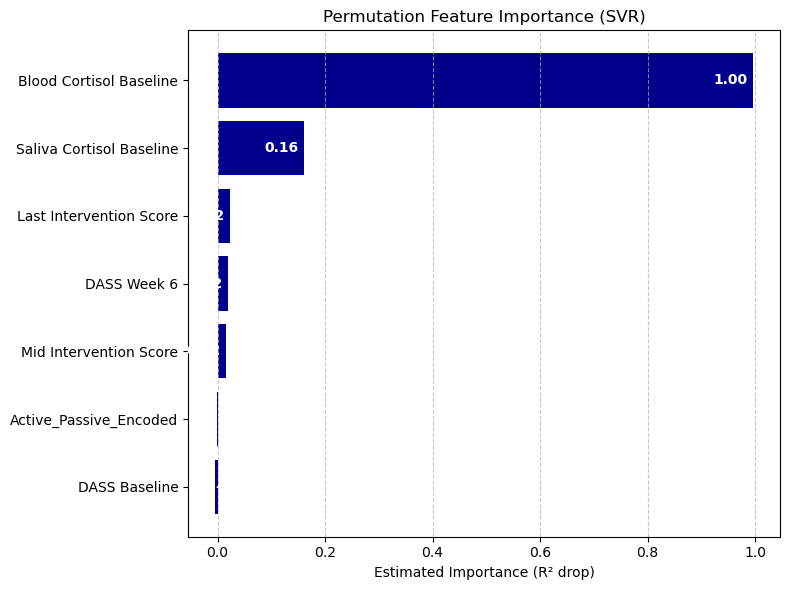

In [79]:
# Compute permutation importances on the test set
perm_importance = permutation_importance(best_svr, X_test_scaled, y_test, n_repeats=30, random_state=42, scoring='r2')

# Create dataframe and sort
importances_df = pd.DataFrame({
    'Feature': features,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=True)

# Plot
plt.figure(figsize=(8, 6))
bars = plt.barh(importances_df['Feature'], importances_df['Importance'], color='darkblue')

# Add white value labels on bars
for bar in bars:
    width = bar.get_width()
    plt.text(width - 0.01 if width > 0.01 else width + 0.001,
             bar.get_y() + bar.get_height() / 2,
             f"{width:.2f}",
             va='center',
             ha='right' if width > 0.01 else 'left',
             color='white',
             fontweight='bold')

plt.xlabel("Estimated Importance (R² drop)")
plt.title("Permutation Feature Importance (SVR)")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [80]:
y_train_pred = best_svr.predict(X_train_scaled)
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_rmse
train_r2

0.6525917734219159

### Random Forest

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Cross-Validated R² (train set): Mean=0.56, Std=0.17
Cross-Validated RMSE (train set): 19.0
Test Set R²: 0.5
Test Set RMSE: 15.55


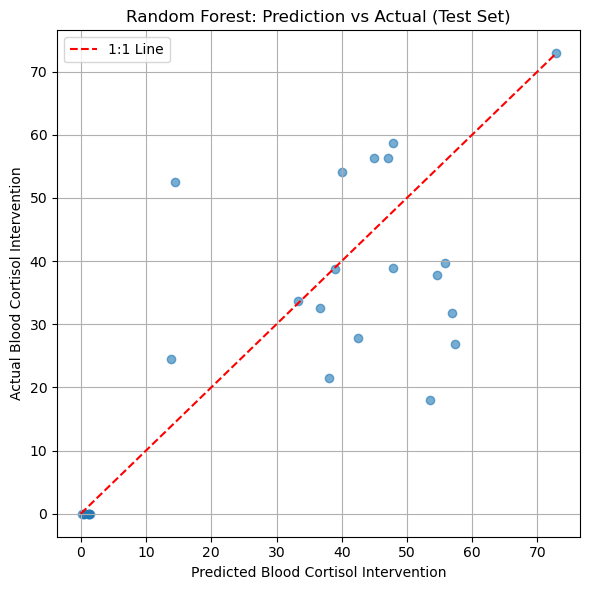

In [25]:
# ---------------------------
# 1. Define features and target
# ---------------------------
X = adults_filled[['Last Intervention Score', 'Saliva Cortisol Baseline', 'DASS Baseline', 'DASS Week 6', 'Blood Cortisol Baseline', 'Mid Intervention Score', 'Active_Passive_Encoded']]
y = adults_filled['Blood Cortisol Intervention']

# ---------------------------
# 2. Train/test split
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---------------------------
# 3. Define hyperparameter grid
# ---------------------------
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# ---------------------------
# 4. Grid Search with Cross-Validation
# ---------------------------
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# ---------------------------
# 5. Cross-validation evaluation on training set
# ---------------------------
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='r2')
cv_predictions = cross_val_predict(best_rf, X_train, y_train, cv=5)
cv_rmse = round(np.sqrt(metrics.mean_squared_error(y_train, cv_predictions)), 2)

print(f"Cross-Validated R² (train set): Mean={cv_scores.mean():.2f}, Std={cv_scores.std():.2f}")
print(f"Cross-Validated RMSE (train set): {cv_rmse}")

# ---------------------------
# 6. Fit best model and test set evaluation
# ---------------------------
best_rf.fit(X_train, y_train)
y_test_pred = best_rf.predict(X_test)

test_r2 = round(metrics.r2_score(y_test, y_test_pred), 2)
test_rmse = round(np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)), 2)

print(f"Test Set R²: {test_r2}")
print(f"Test Set RMSE: {test_rmse}")

# ---------------------------
# 7. Plot Predictions vs Actual on Test Set
# ---------------------------
plt.figure(figsize=(6, 6))
plt.scatter(y_test_pred, y_test, alpha=0.6)
min_val = min(y_test.min(), y_test_pred.min())
max_val = max(y_test.max(), y_test_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='1:1 Line')
plt.xlabel("Predicted Blood Cortisol Intervention")
plt.ylabel("Actual Blood Cortisol Intervention")
plt.title("Random Forest: Prediction vs Actual (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

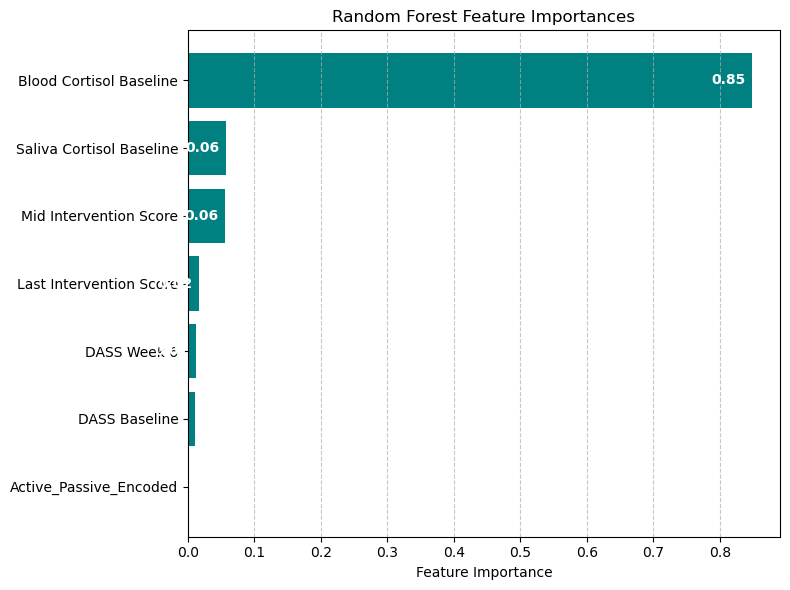

In [26]:
# Get feature importances from the best model
importances = best_rf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

# Plot
plt.figure(figsize=(8, 6))
bars = plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='teal')

# Add values on bars
for bar in bars:
    width = bar.get_width()
    plt.text(width - 0.01 if width > 0.01 else width + 0.001,  # Adjust text position for short bars
             bar.get_y() + bar.get_height()/2,
             f"{width:.2f}",
             va='center',
             ha='right' if width > 0.01 else 'left',
             color='white',
             fontweight='bold')

plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Gradient Boosting

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Tuned Gradient Boosting CV R²: Mean=0.47, Std=0.12
Tuned Gradient Boosting CV RMSE: 21.35
Tuned Gradient Boosting Test Set R²: 0.64
Tuned Gradient Boosting Test Set RMSE: 13.07


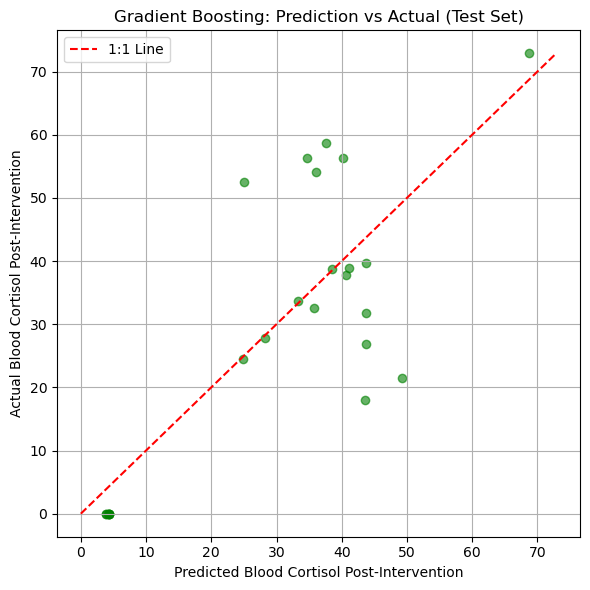

In [68]:
# ---------------------------
# 1. Define features and target
# ---------------------------
X = adults_filled[['Last Intervention Score', 'Saliva Cortisol Baseline', 'DASS Baseline', 'DASS Week 6', 'Blood Cortisol Baseline', 'Mid Intervention Score', 'Active_Passive_Encoded']]
y = adults_filled['Blood Cortisol Intervention']

# ---------------------------
# 2. Train/test split
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---------------------------
# 3. Define hyperparameter grid
# ---------------------------
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# ---------------------------
# 4. Grid Search CV
# ---------------------------
gb = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(gb, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_gb = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# ---------------------------
# 5. Cross-validation on full training set
# ---------------------------
cv_scores = cross_val_score(best_gb, X_train, y_train, cv=5, scoring='r2')
cv_predictions = cross_val_predict(best_gb, X_train, y_train, cv=5)
cv_rmse = round(np.sqrt(metrics.mean_squared_error(y_train, cv_predictions)), 2)

print(f"Tuned Gradient Boosting CV R²: Mean={cv_scores.mean():.2f}, Std={cv_scores.std():.2f}")
print(f"Tuned Gradient Boosting CV RMSE: {cv_rmse}")

# ---------------------------
# 6. Fit best model and test set evaluation
# ---------------------------
best_gb.fit(X_train, y_train)
y_test_pred = best_gb.predict(X_test)

test_r2 = round(metrics.r2_score(y_test, y_test_pred), 2)
test_rmse = round(np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)), 2)

print(f"Tuned Gradient Boosting Test Set R²: {test_r2}")
print(f"Tuned Gradient Boosting Test Set RMSE: {test_rmse}")

# ---------------------------
# 7. Plot Predictions vs Actual on Test Set
# ---------------------------
plt.figure(figsize=(6, 6))
plt.scatter(y_test_pred, y_test, alpha=0.6, color='green')
min_val = min(min(y_test_pred), min(y_test))
max_val = max(max(y_test_pred), max(y_test))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='1:1 Line')
plt.xlabel("Predicted Blood Cortisol Post-Intervention")
plt.ylabel("Actual Blood Cortisol Post-Intervention")
plt.title("Gradient Boosting: Prediction vs Actual (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

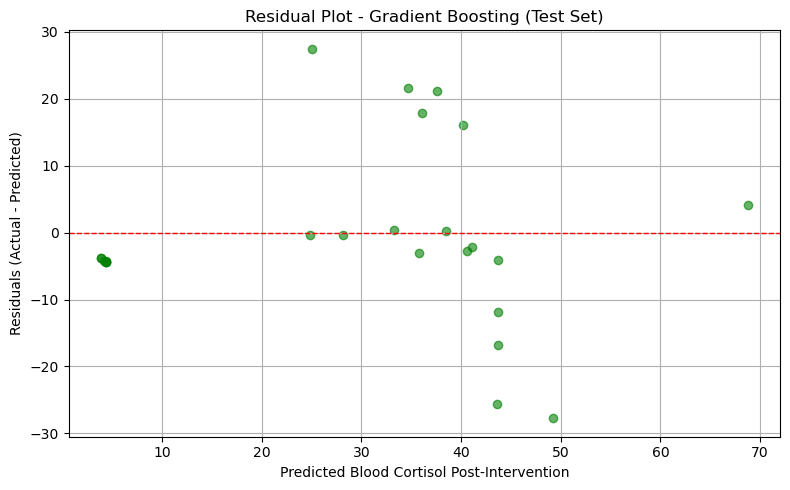

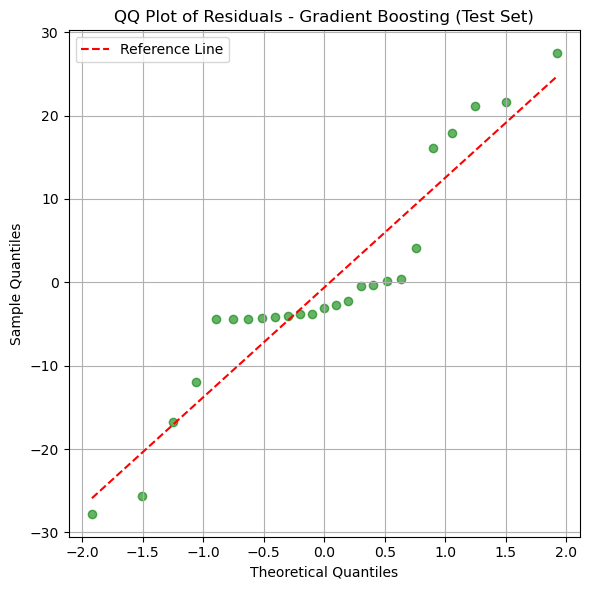

In [73]:
# ---------------------------
# 8. Calculate Residuals
# ---------------------------
residuals = y_test - y_test_pred

# Add residuals to a DataFrame for inspection if needed
residuals_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred,
    'Residual': residuals
})

# ---------------------------
# 9. Plot Residuals
# ---------------------------
plt.figure(figsize=(8, 5))
plt.scatter(y_test_pred, residuals, alpha=0.6, color='green')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel("Predicted Blood Cortisol Post-Intervention")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot - Gradient Boosting (Test Set)")
plt.grid(True)
plt.tight_layout()
plt.show()


import scipy.stats as stats
# Create QQ plot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

# Generate QQ plot values
osm, osr = stats.probplot(residuals, dist="norm", plot=None)

# Scatter plot (green)
ax.scatter(osm[0], osm[1], color='green', alpha=0.6)

# Plot reference line
slope, intercept = osm[1][1], osm[1][0]
line = np.poly1d(np.polyfit(osm[0], osm[1], 1))
ax.plot(osm[0], line(osm[0]), color='red', linestyle='--', label='Reference Line')

ax.set_title("QQ Plot of Residuals - Gradient Boosting (Test Set)")
ax.set_xlabel("Theoretical Quantiles")
ax.set_ylabel("Sample Quantiles")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

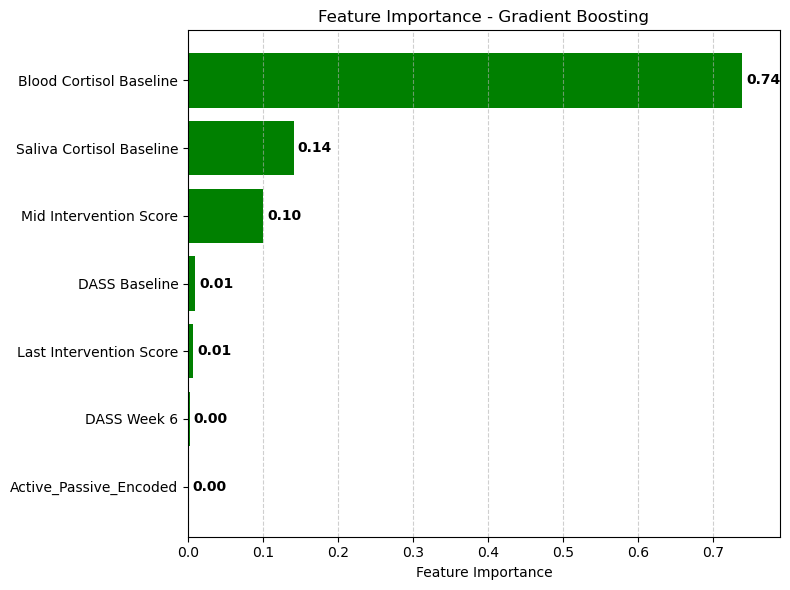

In [65]:
# Get feature importances and corresponding feature names
importances = best_gb.feature_importances_
features = X_train.columns

# Sort in descending order
indices = np.argsort(importances)[::-1]
sorted_features = features[indices]
sorted_importances = importances[indices]

# Plot
plt.figure(figsize=(8, 6))
bars = plt.barh(range(len(sorted_features)), sorted_importances[::-1], color='green')
plt.yticks(range(len(sorted_features)), sorted_features[::-1])
plt.xlabel('Feature Importance')
plt.title('Feature Importance - Gradient Boosting')

# Add black text labels outside the bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.005, 
             bar.get_y() + bar.get_height() / 2,
             f'{sorted_importances[::-1][i]:.2f}',
             va='center', ha='left', color='black', fontsize=10, fontweight='bold')

# Expand x-axis to accommodate labels
max_width = max(sorted_importances)
plt.xlim(0, max_width + 0.05)

plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [29]:
y_train_pred_rf = best_rf.predict(X_train)
train_r2_rf = round(metrics.r2_score(y_train, y_train_pred_rf), 2)
train_rmse_rf = round(np.sqrt(metrics.mean_squared_error(y_train, y_train_pred_rf)), 2)

print(f"Random Forest - Training R²: {train_r2_rf}, RMSE: {train_rmse_rf}")

y_train_pred_gb = best_gb.predict(X_train)
train_r2_gb = round(metrics.r2_score(y_train, y_train_pred_gb), 2)
train_rmse_gb = round(np.sqrt(metrics.mean_squared_error(y_train, y_train_pred_gb)), 2)

print(f"Gradient Boosting - Training R²: {train_r2_gb}, RMSE: {train_rmse_gb}")


y_train_pred_ensemble = (y_train_pred_rf + y_train_pred_gb) / 2
train_r2_ensemble = round(metrics.r2_score(y_train, y_train_pred_ensemble), 2)
train_rmse_ensemble = round(np.sqrt(metrics.mean_squared_error(y_train, y_train_pred_ensemble)), 2)

print(f"Ensemble Model - Training R²: {train_r2_ensemble}, RMSE: {train_rmse_ensemble}")


Random Forest - Training R²: 0.78, RMSE: 13.39
Gradient Boosting - Training R²: 0.87, RMSE: 10.35
Ensemble Model - Training R²: 0.84, RMSE: 11.47


In [30]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# 1. Get predictions from both models on test set
y_pred_rf = best_rf.predict(X_test)
y_pred_gb = best_gb.predict(X_test)

# 2. Average predictions
y_pred_ensemble = (y_pred_rf + y_pred_gb) / 2

# 3. Evaluate ensemble
ensemble_r2 = round(r2_score(y_test, y_pred_ensemble), 2)
ensemble_rmse = round(np.sqrt(mean_squared_error(y_test, y_pred_ensemble)), 2)

print(f"Ensemble Model Test R²: {ensemble_r2}")
print(f"Ensemble Model Test RMSE: {ensemble_rmse}")

Ensemble Model Test R²: 0.61
Ensemble Model Test RMSE: 13.72


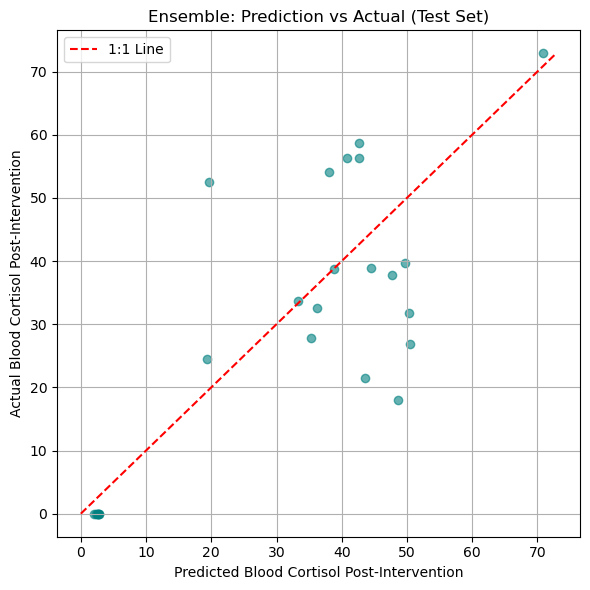

In [31]:
# Plot Predictions vs Actual for Ensemble
plt.figure(figsize=(6, 6))
plt.scatter(y_pred_ensemble, y_test, alpha=0.6, color='teal')
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='1:1 Line')
plt.xlabel("Predicted Blood Cortisol Post-Intervention")
plt.ylabel("Actual Blood Cortisol Post-Intervention")
plt.title("Ensemble: Prediction vs Actual (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Predicting Post-Intervention Salivary Cortisol using Baseline Variables

## Linear Regression Model

In [32]:
# 1. Fill missing values
adults_filled = adults.fillna(0)

# Step 2: Encode Active/Passive
adults_filled['Active_Passive_Encoded'] = adults_filled['Active/Passive'].map({'Passive': 0, 'Active': 1})
adults_filled['Active_Passive_Encoded'] = adults_filled['Active_Passive_Encoded'].fillna(0)

# 2. Rename columns
df_renamed = adults_filled.rename(columns={
    "Last Intervention Score": "Last_Intervention_Score",
    "Session 1 Weighted Sum": "Baseline_Score",
    "Mid Intervention Score": "Mid_Score",
    "Active/Passive": "Active_Passive",
    "DASS Week 16": "DASS_Week_16",
    "DASS Week 12": "DASS_Week_12",
    "DASS Week 6": "DASS_Week_6",
    "DASS Baseline": "DASS_Baseline",
    "Blood Cortisol Baseline": "Blood_Cortisol_Baseline",
    "Blood Cortisol Intervention": "Blood_Cortisol_Intervention",
    "Saliva Cortisol Baseline": "Saliva_Cortisol_Baseline",
    "Saliva Cortisol Intervention": "Saliva_Cortisol_Intervention"
})

# 3. Train-test split
train_df, test_df = train_test_split(df_renamed, test_size=0.2, random_state=42)

# 4. Train the model on the training set
mod1 = smf.ols(
    formula="Saliva_Cortisol_Intervention ~ Blood_Cortisol_Baseline + Saliva_Cortisol_Baseline + DASS_Baseline + Baseline_Score + Mid_Score + DASS_Week_6 + C(Active_Passive_Encoded)",
    data=train_df
)
mod1_res = mod1.fit()

# 5. Print training summary
print(mod1_res.summary())

# 6. Predict on test set
y_pred = mod1_res.predict(test_df)

# 7. Evaluate on test set using R² (correct target!)
test_r2 = r2_score(test_df['Blood_Cortisol_Intervention'], y_pred)
print(f"\nTest Set R²: {test_r2:.2f}")

# 8. Cross-validation
# Select feature columns and target
feature_cols = ['Baseline_Score', 'Mid_Score', 'Saliva_Cortisol_Baseline', 'Blood_Cortisol_Baseline', 'DASS_Baseline', 'DASS_Week_6', 'Active_Passive_Encoded']
X_cv = df_renamed[feature_cols]
X_cv = pd.get_dummies(X_cv, drop_first=True)  # One-hot encode categorical variables
y_cv = df_renamed['Saliva_Cortisol_Intervention']

# Define linear regression model
lr = LinearRegression()

# Perform 5-fold cross-validation for R²
cv_scores = cross_val_score(lr, X_cv, y_cv, cv=5, scoring='r2')

# Report cross-validation results
print(f"\nCross-validated R²: Mean={cv_scores.mean():.2f}, Std={cv_scores.std():.2f}")

                                 OLS Regression Results                                 
Dep. Variable:     Saliva_Cortisol_Intervention   R-squared:                       0.353
Model:                                      OLS   Adj. R-squared:                  0.303
Method:                           Least Squares   F-statistic:                     7.021
Date:                          Fri, 16 May 2025   Prob (F-statistic):           1.12e-06
Time:                                  10:30:19   Log-Likelihood:                -364.90
No. Observations:                            98   AIC:                             745.8
Df Residuals:                                90   BIC:                             766.5
Df Model:                                     7                                         
Covariance Type:                      nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
---------

## SVR Model

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'C': 10, 'epsilon': 0.5, 'gamma': 'scale'}
Cross-validated R²: Mean=0.31, Std=0.39
Cross-validated RMSE: 9.81
Test Set R²: 0.35
Test Set RMSE: 10.93


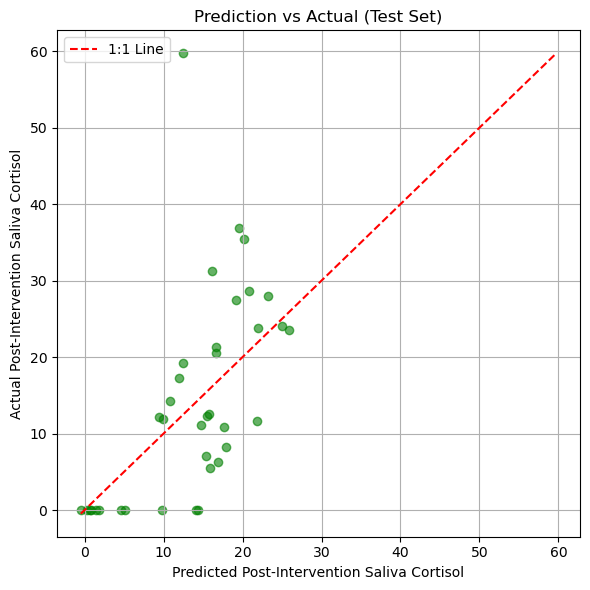

In [33]:
# ---------------------------
# 1. Fill missing values and encode
# ---------------------------
#adults_filled = adults_active.fillna(0)

# ---------------------------
# 2. Train/test split
# ---------------------------
train, test = train_test_split(adults_filled, test_size=0.3, random_state=42)
train = train.sort_values('Last Intervention Score')
test = test.sort_values('Last Intervention Score')

# ---------------------------
# 3. Select features/target
# ---------------------------
features = ['Last Intervention Score', 'Blood Cortisol Baseline',  'Saliva Cortisol Baseline', 'DASS Baseline', 'DASS Week 6', 'Mid Intervention Score', 'Active_Passive_Encoded']
X_train = train[features]
X_test = test[features]
y_train = train['Saliva Cortisol Intervention']
y_test = test['Saliva Cortisol Intervention']

# ---------------------------
# 4. Standardize features
# ---------------------------
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ---------------------------
# 5. Hyperparameter tuning (RBF SVR)
# ---------------------------
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.1, 1],
    'epsilon': [0.01, 0.1, 0.5]
}

svr = SVR(kernel='rbf')
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

best_svr = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# ---------------------------
# 6. Cross-validation on train set
# ---------------------------
cv_scores = cross_val_score(best_svr, X_train_scaled, y_train, cv=5, scoring='r2')
cv_predictions = cross_val_predict(best_svr, X_train_scaled, y_train, cv=5)
cv_rmse = round(np.sqrt(metrics.mean_squared_error(y_train, cv_predictions)), 2)

print(f"Cross-validated R²: Mean={cv_scores.mean():.2f}, Std={cv_scores.std():.2f}")
print(f"Cross-validated RMSE: {cv_rmse}")

# ---------------------------
# 7. Fit best model to train and evaluate on test set
# ---------------------------
best_svr.fit(X_train_scaled, y_train)
y_test_pred = best_svr.predict(X_test_scaled)
test_r2 = round(metrics.r2_score(y_test, y_test_pred), 2)
test_rmse = round(np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)), 2)

print(f"Test Set R²: {test_r2}")
print(f"Test Set RMSE: {test_rmse}")

# ---------------------------
# 8. Plot Predictions vs Actual (Test Set)
# ---------------------------
plt.figure(figsize=(6,6))
plt.scatter(y_test_pred, y_test, alpha=0.6, color='green')
min_val = min(y_test_pred.min(), y_test.min())
max_val = max(y_test_pred.max(), y_test.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='1:1 Line')
plt.xlabel('Predicted Post-Intervention Saliva Cortisol')
plt.ylabel('Actual Post-Intervention Saliva Cortisol')
plt.title('Prediction vs Actual (Test Set)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

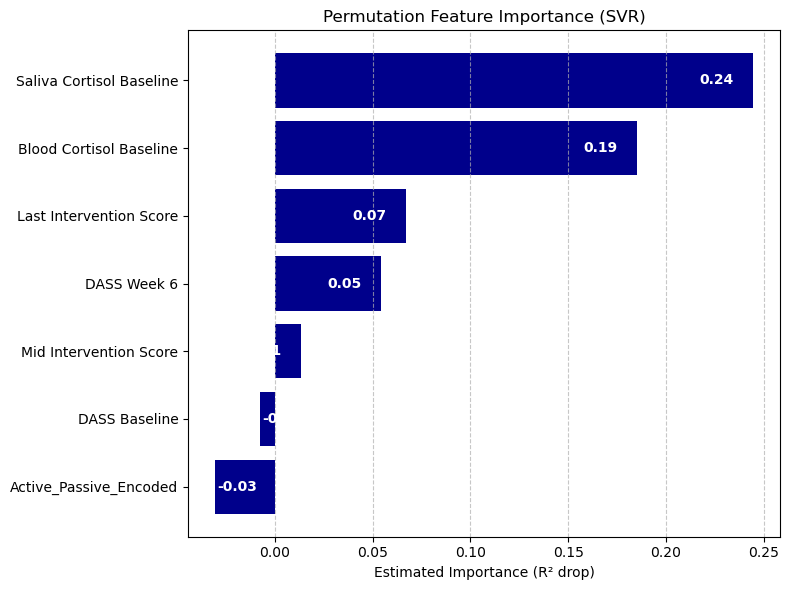

In [34]:
# Compute permutation importances on the test set
perm_importance = permutation_importance(best_svr, X_test_scaled, y_test, n_repeats=30, random_state=42, scoring='r2')

# Create dataframe and sort
importances_df = pd.DataFrame({
    'Feature': features,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=True)

# Plot
plt.figure(figsize=(8, 6))
bars = plt.barh(importances_df['Feature'], importances_df['Importance'], color='darkblue')

# Add white value labels on bars
for bar in bars:
    width = bar.get_width()
    plt.text(width - 0.01 if width > 0.01 else width + 0.001,
             bar.get_y() + bar.get_height() / 2,
             f"{width:.2f}",
             va='center',
             ha='right' if width > 0.01 else 'left',
             color='white',
             fontweight='bold')

plt.xlabel("Estimated Importance (R² drop)")
plt.title("Permutation Feature Importance (SVR)")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [35]:
y_train_pred = best_svr.predict(X_train_scaled)
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(train_rmse)
print(train_r2)

7.604880879750268
0.6428764505453677


## Random Forest Model

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Cross-Validated R² (train set): Mean=0.42, Std=0.23
Cross-Validated RMSE (train set): 9.77
Test Set R²: 0.47
Test Set RMSE: 10.76


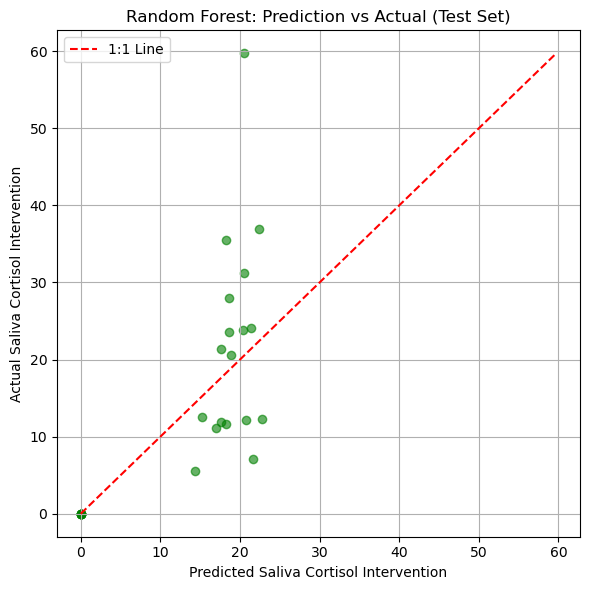

In [86]:
# ---------------------------
# 1. Define features and target
# ---------------------------
X = adults_filled[['Last Intervention Score', 'Mid Intervention Score', 'Saliva Cortisol Baseline', 'Blood Cortisol Baseline', 'DASS Baseline', 'DASS Week 6','Active_Passive_Encoded']]
y = adults_filled['Saliva Cortisol Intervention']

# ---------------------------
# 2. Train/test split
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---------------------------
# 3. Define hyperparameter grid
# ---------------------------
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# ---------------------------
# 4. Grid Search with Cross-Validation
# ---------------------------
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# ---------------------------
# 5. Cross-validation evaluation on training set
# ---------------------------
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='r2')
cv_predictions = cross_val_predict(best_rf, X_train, y_train, cv=5)
cv_rmse = round(np.sqrt(metrics.mean_squared_error(y_train, cv_predictions)), 2)

print(f"Cross-Validated R² (train set): Mean={cv_scores.mean():.2f}, Std={cv_scores.std():.2f}")
print(f"Cross-Validated RMSE (train set): {cv_rmse}")

# ---------------------------
# 6. Fit best model and test set evaluation
# ---------------------------
best_rf.fit(X_train, y_train)
y_test_pred = best_rf.predict(X_test)

test_r2 = round(metrics.r2_score(y_test, y_test_pred), 2)
test_rmse = round(np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)), 2)

print(f"Test Set R²: {test_r2}")
print(f"Test Set RMSE: {test_rmse}")

# ---------------------------
# 7. Plot Predictions vs Actual on Test Set
# ---------------------------
plt.figure(figsize=(6, 6))
plt.scatter(y_test_pred, y_test, alpha=0.6, color='green')
min_val = min(y_test.min(), y_test_pred.min())
max_val = max(y_test.max(), y_test_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='1:1 Line')
plt.xlabel("Predicted Saliva Cortisol Intervention")
plt.ylabel("Actual Saliva Cortisol Intervention")
plt.title("Random Forest: Prediction vs Actual (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

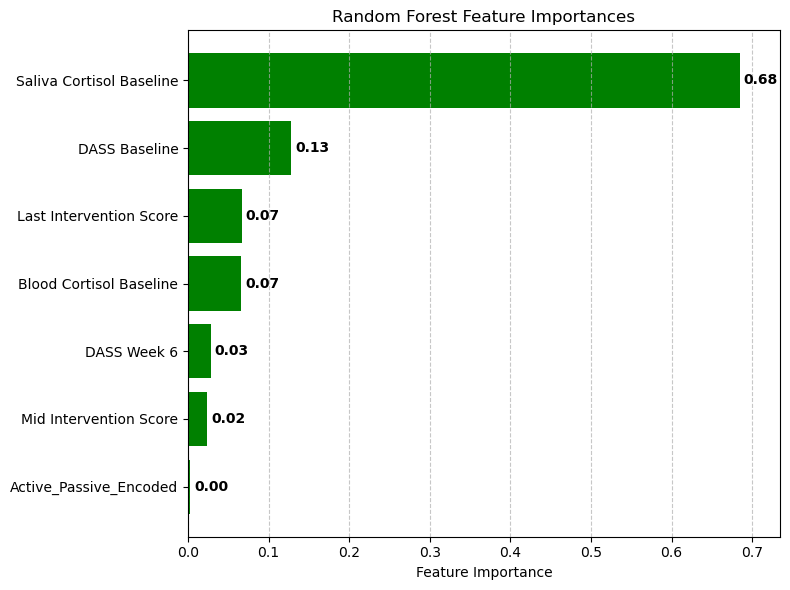

In [87]:
# Get feature importances from the best model
importances = best_rf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

# Plot
plt.figure(figsize=(8, 6))
bars = plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='green')

# Add black values outside bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005,  # push text just outside the bar
             bar.get_y() + bar.get_height()/2,
             f"{width:.2f}",
             va='center',
             ha='left',
             color='black',
             fontweight='bold')

# Expand x-axis to fit labels
max_width = feature_importance_df['Importance'].max()
plt.xlim(0, max_width + 0.05)

plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

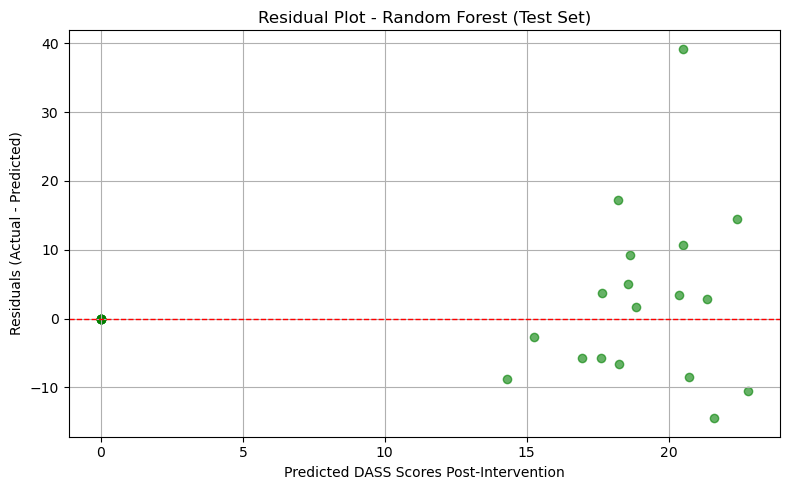

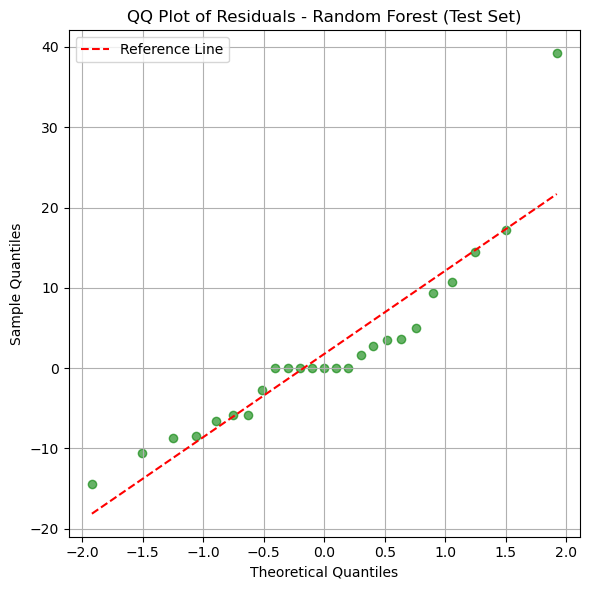

In [88]:
# ---------------------------
# 8. Calculate Residuals
# ---------------------------
residuals = y_test - y_test_pred

# Add residuals to a DataFrame for inspection if needed
residuals_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred,
    'Residual': residuals
})

# ---------------------------
# 9. Plot Residuals
# ---------------------------
plt.figure(figsize=(8, 5))
plt.scatter(y_test_pred, residuals, alpha=0.6, color='green')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel("Predicted DASS Scores Post-Intervention")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot - Random Forest (Test Set)")
plt.grid(True)
plt.tight_layout()
plt.show()


import scipy.stats as stats
# Create QQ plot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

# Generate QQ plot values
osm, osr = stats.probplot(residuals, dist="norm", plot=None)

# Scatter plot (green)
ax.scatter(osm[0], osm[1], color='green', alpha=0.6)

# Plot reference line
slope, intercept = osm[1][1], osm[1][0]
line = np.poly1d(np.polyfit(osm[0], osm[1], 1))
ax.plot(osm[0], line(osm[0]), color='red', linestyle='--', label='Reference Line')

ax.set_title("QQ Plot of Residuals - Random Forest (Test Set)")
ax.set_xlabel("Theoretical Quantiles")
ax.set_ylabel("Sample Quantiles")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

In [38]:
y_train_pred_rf = best_rf.predict(X_train)
train_r2_rf = round(metrics.r2_score(y_train, y_train_pred_rf), 2)
train_rmse_rf = round(np.sqrt(metrics.mean_squared_error(y_train, y_train_pred_rf)), 2)

print(f"Random Forest - Training R²: {train_r2_rf}, RMSE: {train_rmse_rf}")


Random Forest - Training R²: 0.73, RMSE: 6.48


## Gradient Boosting

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Tuned Gradient Boosting CV R²: Mean=0.42, Std=0.16
Tuned Gradient Boosting CV RMSE: 9.81
Tuned Gradient Boosting Test Set R²: 0.33
Tuned Gradient Boosting Test Set RMSE: 12.02


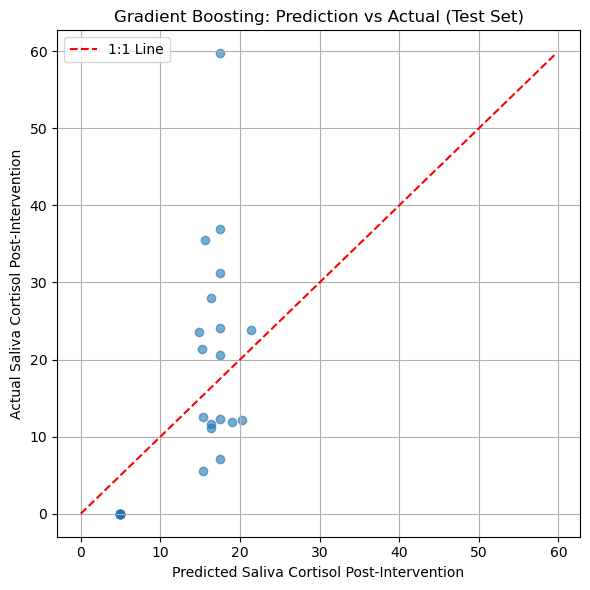

In [39]:
# ---------------------------
# 1. Define features and target
# ---------------------------
X = adults_filled[['Last Intervention Score', 'Saliva Cortisol Baseline', 'Mid Intervention Score', 'Blood Cortisol Baseline', 'DASS Baseline', 'DASS Week 6', 'Active_Passive_Encoded']]
y = adults_filled['Saliva Cortisol Intervention']

# ---------------------------
# 2. Train/test split
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---------------------------
# 3. Define hyperparameter grid
# ---------------------------
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# ---------------------------
# 4. Grid Search CV
# ---------------------------
gb = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(gb, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_gb = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# ---------------------------
# 5. Cross-validation on full training set
# ---------------------------
cv_scores = cross_val_score(best_gb, X_train, y_train, cv=5, scoring='r2')
cv_predictions = cross_val_predict(best_gb, X_train, y_train, cv=5)
cv_rmse = round(np.sqrt(metrics.mean_squared_error(y_train, cv_predictions)), 2)

print(f"Tuned Gradient Boosting CV R²: Mean={cv_scores.mean():.2f}, Std={cv_scores.std():.2f}")
print(f"Tuned Gradient Boosting CV RMSE: {cv_rmse}")

# ---------------------------
# 6. Fit best model and test set evaluation
# ---------------------------
best_gb.fit(X_train, y_train)
y_test_pred = best_gb.predict(X_test)

test_r2 = round(metrics.r2_score(y_test, y_test_pred), 2)
test_rmse = round(np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)), 2)

print(f"Tuned Gradient Boosting Test Set R²: {test_r2}")
print(f"Tuned Gradient Boosting Test Set RMSE: {test_rmse}")

# ---------------------------
# 7. Plot Predictions vs Actual on Test Set
# ---------------------------
plt.figure(figsize=(6, 6))
plt.scatter(y_test_pred, y_test, alpha=0.6)
min_val = min(min(y_test_pred), min(y_test))
max_val = max(max(y_test_pred), max(y_test))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='1:1 Line')
plt.xlabel("Predicted Saliva Cortisol Post-Intervention")
plt.ylabel("Actual Saliva Cortisol Post-Intervention")
plt.title("Gradient Boosting: Prediction vs Actual (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

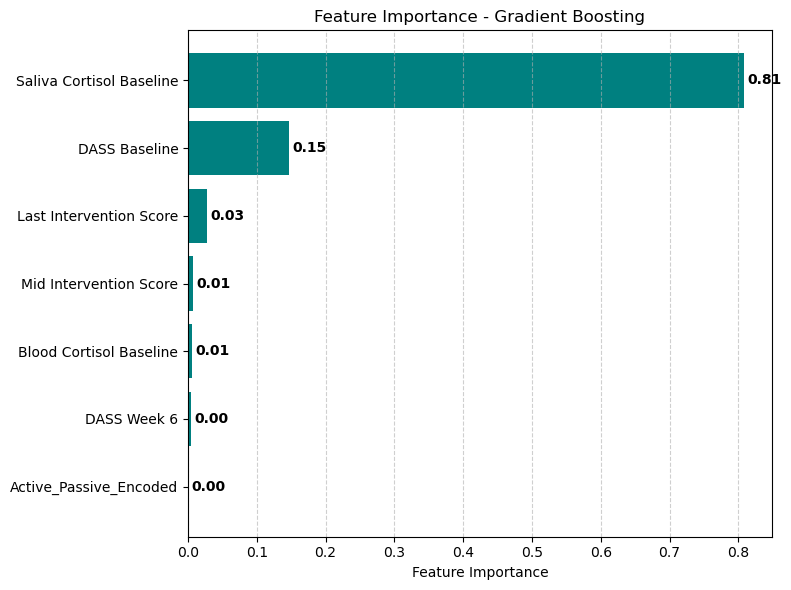

In [40]:
# Get feature importances and corresponding feature names
importances = best_gb.feature_importances_
features = X_train.columns

# Sort in descending order
indices = np.argsort(importances)[::-1]
sorted_features = features[indices]
sorted_importances = importances[indices]

# Plot
plt.figure(figsize=(8, 6))
bars = plt.barh(range(len(sorted_features)), sorted_importances[::-1], color='teal')
plt.yticks(range(len(sorted_features)), sorted_features[::-1])
plt.xlabel('Feature Importance')
plt.title('Feature Importance - Gradient Boosting')

# Add white text labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height() / 2,
             f'{sorted_importances[::-1][i]:.2f}',
             va='center', ha='left', color='black', fontsize=10, fontweight='bold')

plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [41]:


y_train_pred_gb = best_gb.predict(X_train)
train_r2_gb = round(metrics.r2_score(y_train, y_train_pred_gb), 2)
train_rmse_gb = round(np.sqrt(metrics.mean_squared_error(y_train, y_train_pred_gb)), 2)

print(f"Gradient Boosting - Training R²: {train_r2_gb}, RMSE: {train_rmse_gb}")

Gradient Boosting - Training R²: 0.55, RMSE: 8.35
